In [34]:
import requests
import json

In [35]:
apikey = "WFWJxIoLy5DwlwuThYH-ylzgn215LIBZ6LCLGqsFCq0"

In [36]:
BASE_URL = 'https://www.deribit.com/api/v2/'

ENDPOINT = 'public/get_order_book'

In [37]:
def make_request(endpoint, params=None): # Function to make a request to the Deribit API
    headers = {
        'Authorization': f'Bearer {apikey}',
    }
    response = requests.get(BASE_URL + endpoint, params=params, headers=headers)
    return response.json()

# Function to fetch order book data
def get_order_book(instrument, depth=10): # Function to fetch order book data
    #This contains the request parameters
    params = {
        'instrument_name': instrument,
        'depth': depth # Number of levels to fetch from the order book.
        #When you specify a "depth" of 10, for example, it means you want to see the top 10 prices at which traders are willing to buy
        # (the highest bids) and the top 10 prices at which traders are willing to sell (the lowest asks). 
    }
    response = make_request(ENDPOINT, params)
    return response

# Example usage
if __name__ == "__main__":
    instrument_name = 'BTC-PERPETUAL'
    order_book = get_order_book(instrument_name)
    print(json.dumps(order_book, indent=4))

{
    "jsonrpc": "2.0",
    "result": {
        "funding_8h": 1.437e-05,
        "current_funding": 0.0,
        "best_bid_amount": 109380.0,
        "best_ask_amount": 1200.0,
        "estimated_delivery_price": 57843.68,
        "best_bid_price": 57830.5,
        "best_ask_price": 57831.0,
        "interest_value": -0.0007465965718876016,
        "open_interest": 878286490,
        "max_price": 59569.0,
        "min_price": 56098.5,
        "last_price": 57830.5,
        "asks": [
            [
                57831.0,
                1200.0
            ],
            [
                57832.5,
                10020.0
            ],
            [
                57837.0,
                43000.0
            ],
            [
                57837.5,
                1200.0
            ],
            [
                57840.0,
                6050.0
            ],
            [
                57840.5,
                3430.0
            ],
            [
                57842.5,
         

In [38]:
import pandas as pd
from pandas import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm

import datetime as dt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label=''): # Function to plot the implied volatility surface
    fig = plt.figure(3, figsize=(10,10))
    ax=plt.axes(projection='3d')
    ax.set_title('Bitcoin Implied Volatility Surface')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Days To Expiration')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        colors = np.random.rand(len(x2))  
        scatter = ax.scatter3D(x2,y2,z2, c=z2, s=100,label=label, cmap='viridis',depthshade=True)
        fig.colorbar(scatter, ax=ax, pad=0.1, aspect=10)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5, cmap='viridis')
    ax.legend()

In [39]:
%%time

# Get a list of all active BTC options from the Deribit API.
def get_all_active_options(): # Function to get all active options
    import urllib.request, json
    url =  "https://deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
    #https://docs.deribit.com/#public-get_instruments
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode()) # Load the data from the URL using json.loads
       #ur.read() reads the response from the URL. The response is in bytes, so we decode it to a string using decode().
    data = pd.DataFrame(data['result']).set_index('instrument_name') # Convert the data to a pandas DataFrame
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.') # Print the number of active options
    return data


CPU times: user 5 µs, sys: 5 µs, total: 10 µs
Wall time: 13.1 µs


In [40]:

# Filter options based on data available from 'get_instruments'
def filter_options(price, active_options):
    # price is the current price of BTC
    
    #Get Put/Call information
    pc = active_options.index.str.strip().str[-1] # Get the last character of the index (P or C)
    #index.str.strip() removes leading and trailing whitespaces
    #Of an instrument name like BTC-25APR24-59000-P it will return 'P'
    # Set "moneyness"
    active_options['m'] = np.log(active_options['strike']/price) # Calculate the moneyness of the option
    active_options.loc[pc=='P','m'] = -active_options['m'] # If the option is a put, set moneyness to negative
    # Set days until expiration
    active_options['t'] = (active_options['expiration_date']-pd.Timestamp.today()).dt.days # Calculate the days until expiration
    
    # Only include options that are less than 30% from the current price and have less than 91 days until expiration
    active_options = active_options.query('m>0 & m<.3 & t<91') # Filter the options based on moneyness and days until expiration
    #query() is used to filter the DataFrame rows based on a condition
    print(f'{active_options.shape[0]} active options after filter.')
    return active_options

In [11]:
# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name): # Function to get tick data for a given instrument
    import urllib.request, json
    url =  f"https://deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    #https://docs.deribit.com/#public-ticker
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = json_normalize(data['result'])
    data.index = [instrument_name] # Set the index to the instrument name
    return data


In [12]:
def get_all_option_data(): # Function to get all option data
    option_data = get_tick_data('BTC-PERPETUAL') # Get tick data for the perpetual BTC option
    price = option_data.at['BTC-PERPETUAL', 'last_price'] # Get the last price of the perpetual BTC option
    options = filter_options(price, get_all_active_options()) # Filter the options based on the last price of the perpetual BTC option
    #30% moneyness and 91 days until expiration
    data_list = [option_data]  # Start with initial option data

    # Retrieve tick data for each option and add to the list
    for o in options.index:
        tick_data = get_tick_data(o)
        data_list.append(tick_data)

    # Concatenate all DataFrame objects in the list
    option_data = pd.concat(data_list)
    return option_data


In [19]:

# Get data
option_data = get_all_option_data()
#Create option_data DataFrame, wich is a concatenation of the tick data for the perpetual BTC option and the tick data for all active options
# Initialize additional columns
option_data['t'] = np.nan # Days until expiration
option_data['strike'] = np.nan # Strike price

# Ensure you start processing from the first option onward (ignoring 'BTC-PERPETUAL' at index 0)
# Adjust indexing method to use .iloc for integer location based operations
try:
    expiration_dates = pd.to_datetime(option_data.iloc[1:].index.map(lambda x: x.split('-')[1]), format='%Y%m%d', errors='coerce') 
    # Extract expiration dates from the index, which is the second element when splitting by '-'. 
    # Start from the second index. (so we only get the expiration dates of the options)
    days_until_expiration = (expiration_dates - pd.Timestamp.today()).days # Calculate the days until expiration
    option_data.iloc[1:, option_data.columns.get_loc('t')] = days_until_expiration # Set the 't' column to the days until expiration
    #Since the first index is 'BTC-PERPETUAL', wich is the bitcoin stock, we start from the second index whose are options.
except Exception as e:
    print(f"Error processing expiration dates: {e}")

try:
    strikes = option_data.iloc[1:].index.map(lambda x: x.split('-')[2]).astype(int) 
    # Extract the strike prices from the index, which is the third element when splitting by '-'
    option_data.iloc[1:, option_data.columns.get_loc('strike')] = strikes
except Exception as e:
    print(f"Error processing strike prices: {e}")

# Calculate "moneyness"
try:
    if not option_data.empty and 'last_price' in option_data.columns: # Check if the DataFrame is not empty and contains 'last_price'
        first_price = option_data.iloc[0]['last_price']  # Assumes the first index is 'BTC-PERPETUAL'
        option_data['m'] = np.log(first_price / option_data['strike'])
except ZeroDivisionError:
    print("Division by zero encountered in 'moneyness' calculation.")
except Exception as e:
    print(f"Error during 'moneyness' calculation: {e}")


988 active options.
252 active options after filter.


/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_14443/1327661093.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  option_data = pd.concat(data_list)


In [20]:
# Calculated days until expiration
# Assuming option_data's index contains the date information in the second segment after splitting by '-'
expiration_dates = pd.to_datetime(option_data.iloc[1:].index.map(lambda x: x.split('-')[1]), errors='coerce')
# Calculate the days directly from the TimedeltaIndex
days_until_expiration = (expiration_dates - pd.Timestamp.today()).days
option_data.iloc[1:, option_data.columns.get_loc('t')] = days_until_expiration

# Pull strike from instrument name
# Assuming option_data's index contains the strike price information in the third segment after splitting by '-'
option_data.iloc[1:, option_data.columns.get_loc('strike')] = option_data.iloc[1:].index.map(lambda x: x.split('-')[2]).astype(int)

# Calculate "moneyness"
# Assuming 'last_price' is stored in the DataFrame and is consistent across the DataFrame
if 'last_price' in option_data.columns:
    first_price = option_data.iloc[0]['last_price']  # Correctly using .iloc to access the first row
    option_data['m'] = np.log(first_price / option_data['strike'])
else:
    print("Error: 'last_price' not found in option_data columns.")


/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_14443/4243206360.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  expiration_dates = pd.to_datetime(option_data.iloc[1:].index.map(lambda x: x.split('-')[1]), errors='coerce')


In [21]:
option_data.columns

Index(['funding_8h', 'current_funding', 'best_bid_amount', 'best_ask_amount',
       'estimated_delivery_price', 'best_bid_price', 'best_ask_price',
       'interest_value', 'open_interest', 'max_price', 'min_price',
       'last_price', 'settlement_price', 'instrument_name', 'mark_price',
       'index_price', 'state', 'timestamp', 'stats.volume_notional',
       'stats.volume_usd', 'stats.volume', 'stats.price_change', 'stats.low',
       'stats.high', 'bid_iv', 'ask_iv', 'underlying_index',
       'underlying_price', 'mark_iv', 'interest_rate', 'greeks.rho',
       'greeks.theta', 'greeks.vega', 'greeks.gamma', 'greeks.delta', 't',
       'strike', 'm'],
      dtype='object')

In [22]:
#Lets save the option_data DataFrame to a CSV file
option_data.to_csv('option_data.csv')

In [13]:
#Let read the option_data DataFrame from the CSV file
option_data = pd.read_csv('option_data.csv', index_col=0)

In [14]:
option_data['last_price'][0] # Last price of the perpetual BTC option

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_39669/2057754057.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  option_data['last_price'][0] # Last price of the perpetual BTC option


64078.0

In [15]:
#Lets get only the call options
call_options = option_data[option_data.index.str.contains('-C')] # Get only the call options
#lets add the first row of the option_data DataFrame to the call_options DataFrame
call_options = pd.concat([option_data.iloc[[0]],call_options])
call_options

,funding_8h,current_funding,best_bid_amount,best_ask_amount,estimated_delivery_price,best_bid_price,best_ask_price,interest_value,open_interest,max_price,...,mark_iv,interest_rate,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,t,strike,m
BTC-PERPETUAL,-0.000004,0.0,162130.0,4280.0,64071.72,64071.5000,64072.0000,-0.002071,835292520.0,65998.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BTC-28APR24-64500-C,NaN,NaN,36.5,10.6,64051.17,0.0003,0.0011,NaN,39.6,0.0325,...,31.05,0.0,0.04955,-36.35304,3.42478,0.00055,0.15755,0.0,64500.0,-0.006564
BTC-28APR24-65000-C,NaN,NaN,4.5,14.4,64048.61,0.0001,0.0006,NaN,177.6,0.0275,...,41.17,0.0,0.01717,-13.50213,1.57282,0.00019,0.05461,0.0,65000.0,-0.014286
BTC-28APR24-65500-C,NaN,NaN,0.1,22.1,64047.23,0.0001,0.0005,NaN,102.4,0.0245,...,51.08,0.0,0.00769,-6.67346,0.81651,0.00008,0.02448,0.0,65500.0,-0.021949
BTC-28APR24-66000-C,NaN,NaN,0.0,27.0,64045.27,0.0000,0.0005,NaN,208.0,0.0220,...,58.21,0.0,0.00323,-2.87477,0.38763,0.00003,0.01026,0.0,66000.0,-0.029554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BTC-26JUL24-80000-C,NaN,NaN,39.6,6.0,64031.39,0.0465,0.0485,NaN,64.7,0.1070,...,59.77,0.0,39.68487,-37.43722,111.70995,0.00002,0.29620,89.0,80000.0,-0.221926
BTC-26JUL24-82000-C,NaN,NaN,20.7,6.0,64036.35,0.0415,0.0435,NaN,35.8,0.1005,...,60.17,0.0,36.33581,-36.05280,106.86150,0.00002,0.27003,89.0,82000.0,-0.246618
BTC-26JUL24-84000-C,NaN,NaN,21.0,6.1,64040.32,0.0370,0.0390,NaN,9.6,0.0945,...,60.61,0.0,33.26673,-34.62220,101.88544,0.00002,0.24626,89.0,84000.0,-0.270716
BTC-26JUL24-85000-C,NaN,NaN,21.2,6.0,64037.06,0.0350,0.0370,NaN,0.0,0.0915,...,60.86,0.0,31.83623,-33.91514,99.38824,0.00002,0.23529,89.0,85000.0,-0.282550


/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_39669/2190775895.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = (option_data['last_price'][0]/option_data_['strike'])


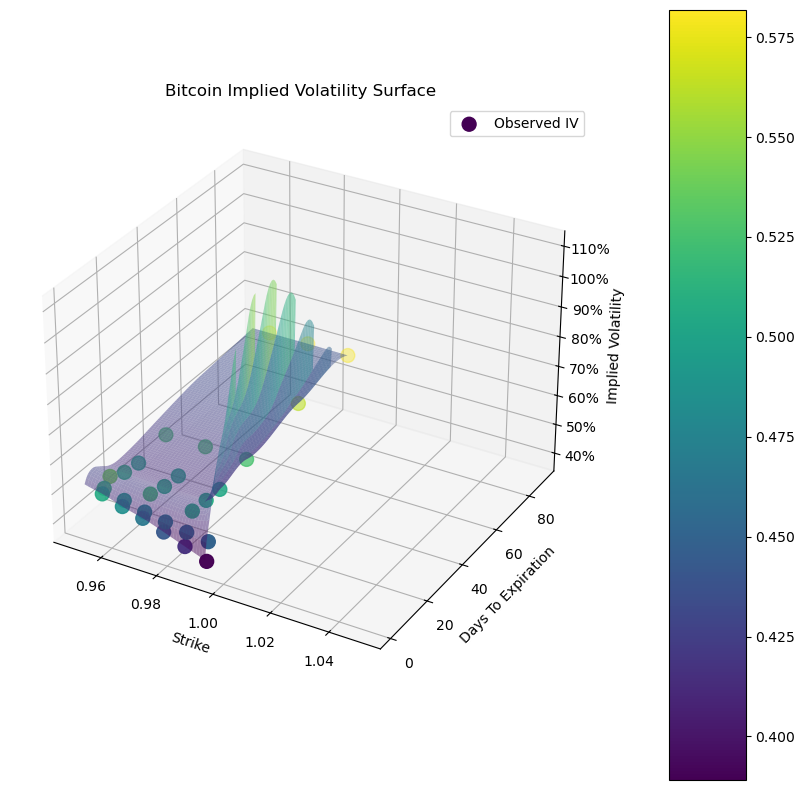

In [16]:
%matplotlib inline
#pip install ipympl
# Interpolate implied volatility using a cubic spline
# Then plot the implied volatility surface

option_data_ = call_options.iloc[1:].sort_values(['t','strike']).query('t>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['t']
z = option_data_['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))

In [34]:
#Lets create an interactive 3d plot of the implied volatility surface
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Surface(z=iv_df.values, x=iv_df.columns, y=iv_df.index)])
fig.update_layout(title='Implied Volatility Surface', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
#Lets define the labels for the axes
fig.update_layout(scene = dict(
                    xaxis_title='Strike',
                    yaxis_title='Days To Expiration',
                    zaxis_title='Implied Volatility'),
                    )
fig.show()

In [43]:
iv_df.iloc[30]

0.950000    0.518260
0.951020    0.518230
0.952041    0.518242
0.953061    0.518215
0.954082    0.518162
              ...   
1.045918         NaN
1.046939         NaN
1.047959         NaN
1.048980         NaN
1.050000         NaN
Name: 33.93939393939394, Length: 99, dtype: float64

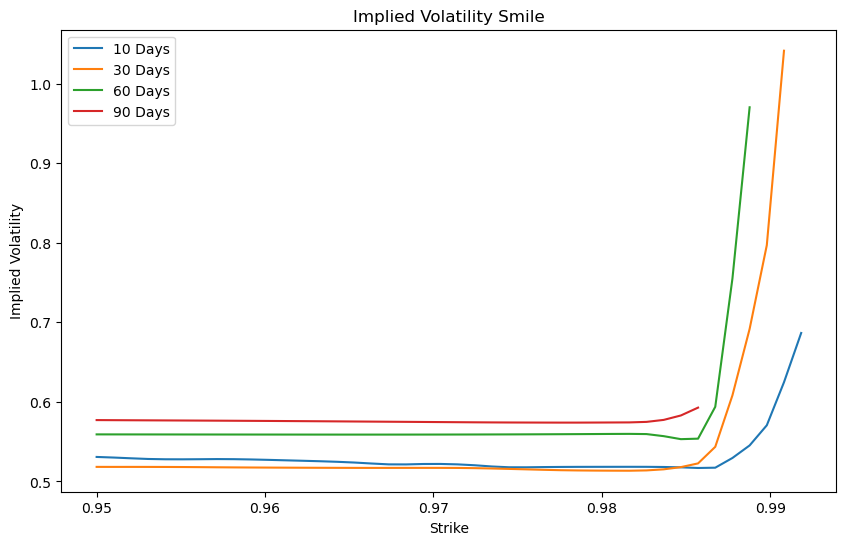

In [44]:
#Lets create a smile plot, of the implied volatility  vs the strike price
plt.figure(figsize=(10,6))
plt.plot(iv_df.columns,iv_df.iloc[10],label='10 Days')
plt.plot(iv_df.columns,iv_df.iloc[30],label='30 Days')
plt.plot(iv_df.columns,iv_df.iloc[60],label='60 Days')
plt.plot(iv_df.columns,iv_df.iloc[90],label='90 Days')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile')
plt.legend()
plt.show()

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_14443/2002118152.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



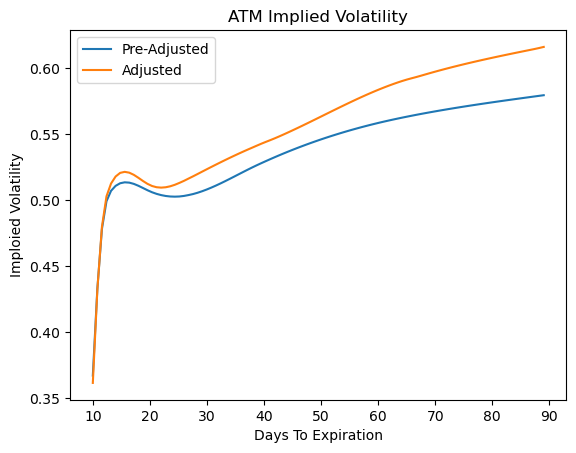

In [39]:
price_diff = option_data['mark_price'][0]-option_data['underlying_price'] # Calculate the price difference
option_data['iv_adj'] = option_data['mark_iv']+(option_data['greeks.delta']*price_diff)/(option_data['greeks.vega'])
option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')

Z = interpolate.griddata(np.array([x,y]).T,np.array(option_data_['iv_adj']/100),(X,Y), method='cubic')
iv_df_adj = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))
iv_df.loc[:,1].plot(label='Pre-Adjusted')
(iv_df_adj.loc[:,1]).plot(label='Adjusted')
plt.xlabel('Days To Expiration')
plt.ylabel('Imploied Volatility')
plt.legend()
plt.title('ATM Implied Volatility')
plt.show()

/Users/luisj/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



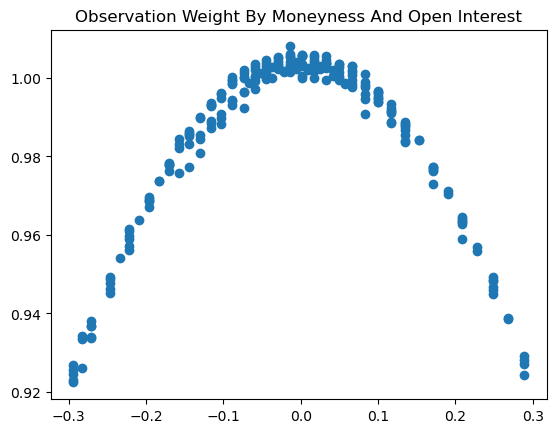

In [40]:
weights = 1/(1+((option_data_['m']**2)))+((np.log(option_data_['open_interest']).replace(-np.inf,0)/np.log(option_data_['open_interest']).replace(-np.inf,0).sum()))
#weights is a function of moneyness and open interest
plt.scatter(option_data_['m'],weights)
plt.title('Observation Weight By Moneyness And Open Interest')
plt.show()

In [67]:
option_data_reg = option_data.iloc[1:].sort_values(['t','strike'])
t = np.sqrt(option_data_['t']/365)
m = np.log(option_data['last_price'][0]/option_data_['strike'])/t
X = pd.DataFrame({'M':m,'M2':m**2,'M3':m**3,'t':t,'tM':t*m,'t2':t**2})
y = (option_data_['iv_adj']/100)

X = sm.add_constant(X) 
model = sm.WLS(y, X, weights=weights).fit()

print(model.summary())

                            WLS Regression Results                            
Dep. Variable:                 iv_adj   R-squared:                       0.897
Model:                            WLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     262.7
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           7.88e-87
Time:                        16:09:21   Log-Likelihood:                 251.79
No. Observations:                 189   AIC:                            -489.6
Df Residuals:                     182   BIC:                            -466.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6924      0.018     39.320      0.0

/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/32180863.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = np.log(option_data['last_price'][0]/option_data_['strike'])/t


/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/1819888550.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = (option_data['last_price'][0]/option_data_['strike'])


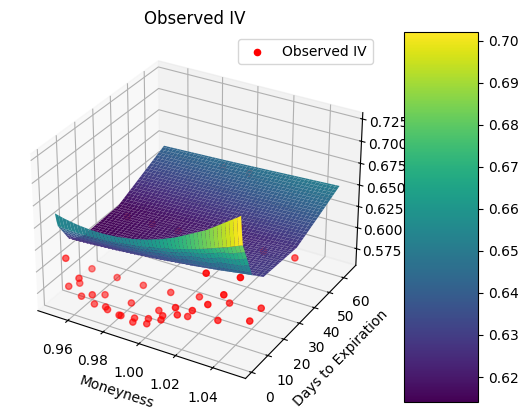

In [68]:
option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['t']
z = model.predict(X)

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='linear')

xyz = pd.DataFrame({'x':x,'y':y,'z':(option_data_['mark_iv']/100)})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df_fit = pd.DataFrame(Z, index=np.linspace(5,np.max(y),100), columns=np.linspace(.95,1.05,99))

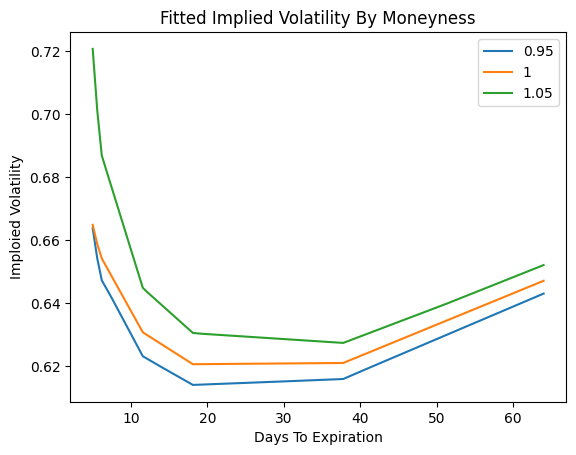

In [69]:
plt.plot(iv_df_fit.loc[:,[.95,1,1.05]])
plt.xlabel('Days To Expiration')
plt.ylabel('Imploied Volatility')
plt.legend(['0.95','1','1.05'])
plt.title('Fitted Implied Volatility By Moneyness')
plt.show()


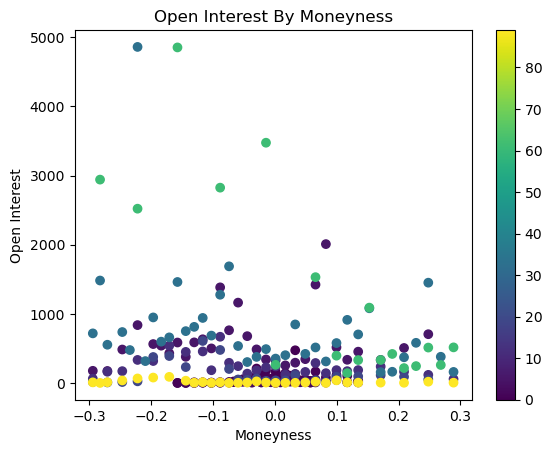

In [32]:
#Lets graph the moneyness with the open interest
import matplotlib.pyplot as plt
plt.scatter(option_data['m'],option_data['open_interest'],c=option_data['t'])
plt.colorbar()
plt.xlabel('Moneyness')
plt.ylabel('Open Interest')
plt.title('Open Interest By Moneyness')
plt.show()


In [31]:
option_data = option_data.fillna(0)
#lets drop the first row
option_data = option_data.iloc[1:]
#lets try to plot a trend
x = option_data['m']
y = option_data['t']
z = option_data['open_interest']
X,Y = np.meshgrid(np.linspace(np.min(x),np.max(x),100),np.linspace(np.min(y),np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='linear')

#lets do a plotly 3d plot
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='Open Interest Trend', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Days To Expiration',
                    zaxis_title='Open Interest')
                    )
fig.show()


In [33]:
#Lets fin the top values of open interest
top_open_interest = option_data.sort_values('open_interest',ascending=False).head(10)
top_open_interest

,funding_8h,current_funding,best_bid_amount,best_ask_amount,estimated_delivery_price,best_bid_price,best_ask_price,interest_value,open_interest,max_price,...,mark_iv,interest_rate,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,t,strike,m
BTC-31MAY24-80000-C,0.0,0.0,64.2,17.5,64019.51,0.0095,0.0105,0.0,4861.5,0.0415,...,58.02,0.0,6.65526,-34.68068,39.65864,0.00002,0.12374,33.0,80000.0,-0.221926
BTC-28JUN24-75000-C,0.0,0.0,10.3,10.5,64017.28,0.0415,0.0425,0.0,4854.2,0.0955,...,57.96,0.0,29.24079,-44.44687,93.82444,0.00002,0.31102,61.0,75000.0,-0.157387
BTC-28JUN24-65000-C,0.0,0.0,9.9,9.6,64018.41,0.0900,0.0915,0.0,3475.4,0.1495,...,56.26,0.0,49.10216,-48.44034,105.34975,0.00003,0.54239,61.0,65000.0,-0.014286
BTC-28JUN24-85000-C,0.0,0.0,0.9,7.6,64021.44,0.0200,0.0210,0.0,2941.6,0.0645,...,61.15,0.0,16.26367,-33.58578,67.19358,0.00002,0.16996,61.0,85000.0,-0.282550
BTC-28JUN24-70000-C,0.0,0.0,10.6,14.0,64017.23,0.0610,0.0625,0.0,2825.2,0.1190,...,56.87,0.0,38.56860,-48.16887,103.62357,0.00003,0.41662,61.0,70000.0,-0.088394
BTC-28JUN24-80000-C,0.0,0.0,17.1,18.2,64016.51,0.0285,0.0295,0.0,2521.0,0.0775,...,59.39,0.0,21.79883,-39.08583,80.52336,0.00002,0.22941,61.0,80000.0,-0.221926
BTC-3MAY24-59000-P,0.0,0.0,1.0,0.6,64071.17,0.0036,0.0040,0.0,2008.5,0.0320,...,58.79,0.0,-1.03786,-81.65972,14.38485,0.00004,-0.11025,5.0,59000.0,0.082564
BTC-31MAY24-69000-C,0.0,0.0,16.5,0.7,64021.08,0.0355,0.0365,0.0,1687.0,0.0815,...,53.07,0.0,19.02913,-58.14767,72.69776,0.00004,0.36145,33.0,69000.0,-0.074005
BTC-28JUN24-60000-P,0.0,0.0,5.3,7.1,64021.07,0.0550,0.0565,0.0,1530.4,0.1130,...,56.24,0.0,-41.37341,-43.92654,95.56909,0.00002,-0.32487,61.0,60000.0,0.065757
BTC-31MAY24-85000-C,0.0,0.0,15.0,9.3,64012.05,0.0060,0.0065,0.0,1481.7,0.0330,...,61.47,0.0,4.28405,-26.58003,28.69155,0.00001,0.07944,33.0,85000.0,-0.282550
